# Data exploration
Since the positioning functions of GNSS and Mobile Network work independently of each other and do not affect each other, the Mobile Network part is extracted separately for analysis and exploration.  
We extracted a file from the long-term data as the object of analysis to find whether there are **some features** included in the source file that can meet the task requirements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import webbrowser as web
from folium.plugins import HeatMap
import seaborn as sns
import sklearn.preprocessing as preprocessing
import plotly.express as px
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# 01_211203_TUDA_data.csv
dtype = {'wagon_ID': str,
         'timestamp_measure_position': str,
         'timestamp_transfer': str,
         'determination_position': int,
         'timestamp_index': str,
         'latitude': float,
         'longitude': float}

use_cols = ['determination_position',
            'wagon_ID',
            'timestamp_measure_position',
            'timestamp_transfer',
            'timestamp_index',
            'latitude',
            'longitude']

wagon_info = pd.read_csv('/Users/dong/Downloads/000_Data/01_211203_TUDA_data.csv', dtype=dtype, usecols=use_cols)
print('loading_finish')

loading_finish


In [4]:
# Extract the data with 'determination'=4，Location determined by Mobile Network
wagon_info = wagon_info[wagon_info['determination_position'] == 4]

Based on the source files, the data known to be potentially relevant to Mobile Network are：

**1.'timestamp_transfer'**  
**2.'timestamp_measure_position'**  
**3.'timestamp_index'**  
  
Using the above known data two new FEATURES can be obtained：**'time_gap'** and **'delay'**.  
It is assumed that the smaller the 'time_gap' or 'delay' is, the better the quality of the location provided by Mobile Network.

In [5]:
# Convert time format
wagon_info['timestamp_measure_position'] = wagon_info['timestamp_measure_position'].dropna()
wagon_info['timestamp_transfer'] = wagon_info['timestamp_transfer'].dropna()
wagon_info['timestamp_index'] = wagon_info['timestamp_index'].dropna()
wagon_info['timestamp_measure_position'] = pd.to_timedelta(wagon_info['timestamp_measure_position'])
wagon_info['timestamp_transfer'] = pd.to_timedelta(wagon_info['timestamp_transfer'])
wagon_info['timestamp_index'] = pd.to_timedelta(wagon_info['timestamp_index'])

# Conversion time in hours
wagon_info['time_gap'] = (wagon_info['timestamp_transfer'] - wagon_info['timestamp_measure_position']).apply(lambda x: x.total_seconds() / 3600)
wagon_info['delay'] = (wagon_info['timestamp_index'] - wagon_info['timestamp_transfer']).apply(lambda x: x.total_seconds() / 3600)

In [6]:
wagon_info.describe()

,latitude,longitude,determination_position,timestamp_measure_position,timestamp_transfer,timestamp_index,time_gap,delay
count,4.947738e+06,4.947738e+06,4947738.0,4947738,4947738,4947738,4.947738e+06,4.947738e+06
mean,5.080483e+01,9.350705e+00,4.0,6 days 09:35:35.977249077,6 days 15:50:15.520763763,6 days 15:50:23.602550297,6.244318e+00,2.244941e-03
std,2.324987e+00,2.973541e+00,0.0,1 days 23:34:22.807144737,2 days 00:07:34.338620302,2 days 00:07:34.114038086,7.490625e+00,8.070431e-02
min,3.803515e+01,-4.120857e+00,4.0,2 days 23:00:00,2 days 23:00:02.991000,2 days 23:00:06,0.000000e+00,3.888889e-06
25%,4.945983e+01,7.167376e+00,4.0,4 days 16:30:06,4 days 22:45:07.524000,4 days 22:45:10,5.734167e-01,5.013889e-04
50%,5.136495e+01,8.654176e+00,4.0,6 days 09:29:01,6 days 14:49:08.989000,6 days 14:49:13,3.964429e+00,6.861111e-04
75%,5.167260e+01,1.108489e+01,4.0,8 days 01:52:44,8 days 08:13:14.002000,8 days 08:13:20,9.846241e+00,1.479722e-03
max,6.780103e+01,2.865417e+01,4.0,9 days 22:59:59,10 days 10:00:28.555000,10 days 10:00:31,1.776100e+02,6.627198e+01


<AxesSubplot:xlabel='delay', ylabel='Density'>

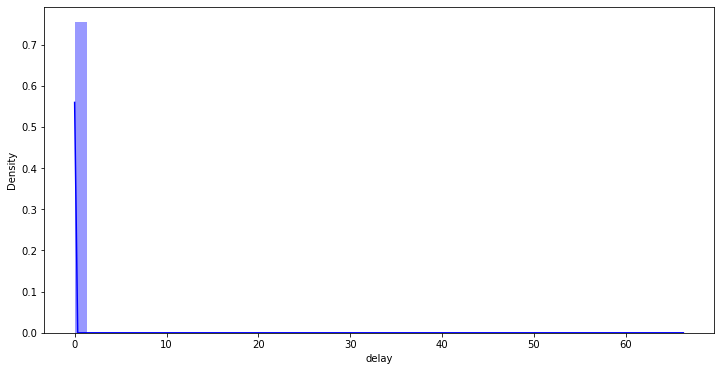

In [7]:
# Density probability distribution diagram about 'delay'
plt.figure(figsize=(12, 6))
sns.distplot(wagon_info['delay'], norm_hist=False, color="b", label="delay")

In feature 'delay', according to the statistics and density probability histogram, more than 75% of the data are less than the mean value, which does not conform to the law of normal distribution, so it is not suitable as a relevant feature.

<AxesSubplot:xlabel='time_gap', ylabel='Density'>

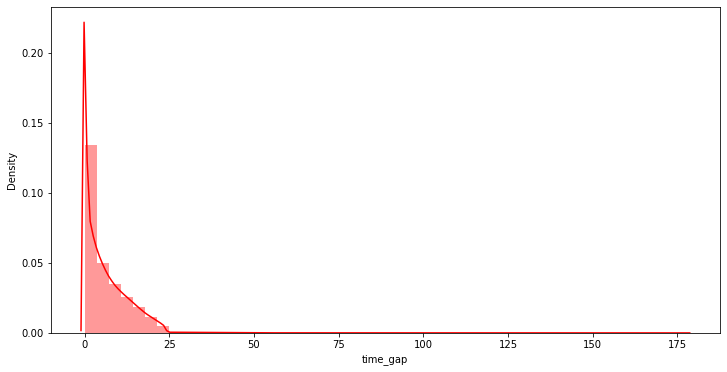

In [8]:
# ensity probability distribution diagram about 'time_gap'
plt.figure(figsize=(12, 6))
sns.distplot(wagon_info['time_gap'], norm_hist=False, color="r", label="time_gap")

In [9]:
# Extracting two different sets of data
wagon_info_1 = wagon_info.drop(wagon_info[wagon_info['time_gap'] > 1].index)
wagon_info_2 = wagon_info.drop(wagon_info[wagon_info['time_gap'] < 1].index)

In [10]:
# create geographic heat map
m1 = folium.Map(location=[wagon_info_1['latitude'].mean(), wagon_info_1['longitude'].mean()],
               zoom_start=6,
               language="en",
               tiles='https://a.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png',
               attr='default')
lat1 = np.array(wagon_info_1['latitude'][0:len(wagon_info_1)])
lon1 = np.array(wagon_info_1['longitude'][0:len(wagon_info_1)])
new_data1 = [[lat1[i], lon1[i]] for i in range(len(wagon_info_1))]
HeatMap(new_data1, radius=15).add_to(m1)
m1.save('/Users/dong/Downloads/result_time_gap<1hours.html')
web.open('/Users/dong/Downloads/result_time_gap<1hours.html')

m2 = folium.Map(location=[wagon_info_2['latitude'].mean(), wagon_info_2['longitude'].mean()],
               zoom_start=6,
               language="en",
               tiles='https://a.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png',
               attr='default')
lat2 = np.array(wagon_info_2['latitude'][0:len(wagon_info_2)])
lon2 = np.array(wagon_info_2['longitude'][0:len(wagon_info_2)])
new_data2 = [[lat2[i], lon2[i]] for i in range(len(wagon_info_2))]
HeatMap(new_data2, radius=15).add_to(m1)
m2.save('/Users/dong/Downloads/result_time_gap>1hours.html')
web.open('/Users/dong/Downloads/result_time_gap>1hours.html')

True

In the feature "time_gap", according to the statistics and the density probability histogram, it conforms to the normal distribution pattern and is suitable as a relevant feature.   
However, by the two different sets of extracted data, both presented in the form of a geographical heat map, it is observed that both sets of data have many locations located outside the railroad line and are not significantly different. Therefore, this feature does not fully describe the quality of the mobile network.

## Conclusion

By exploring the dataset, the known FEATURES do not meet the task requirements well. Therefore, we need to extract other features that have a possible relationship with Mobile Network.